In [2]:
# Installing Dependencies
!pip install pandas numpy tensorflow matplotlib gradio jinja2

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
import zipfile

from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Bidirectional,Dropout,Dense,Embedding

from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [6]:
# Read The data
df_zip = zipfile.ZipFile('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
df = pd.read_csv(df_zip.open('train.csv'))

In [8]:
# Check The data
df.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
45060,7877fc0d3990f9a2,"""\nThe practice: 1. only (central) governmenta...",0,0,0,0,0,0
10903,1cce601c140db849,Playing god again==\nBut time the deletion naz...,1,0,1,0,1,0
132741,c6397365ac0b6682,"I will try to clean this page up some,this pag...",0,0,0,0,0,0
23422,3ddb22d7327c0d04,you need to re-read the purpose of wikipedia,0,0,0,0,0,0
58702,9d36b967b931ae2e,It is appropriate \n\nIMHO as that category is...,0,0,0,0,0,0


In [9]:
# Use to tokenize our data
X = df['comment_text']
y = df[df.columns[2:]].values

MAX_FEATURES = 150000

vectorizer = TextVectorization(max_tokens=MAX_FEATURES,output_sequence_length=1800,output_mode='int')

In [13]:
# Fit the vectorizer
vectorizer.adapt(X.values)

2023-02-08 20:50:50.225938: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [14]:
# Lets test It
vectorizer("Hey, how are you")[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([425,  73,  20,   7,   0])>

In [15]:
#Storing it in a matrix
vectorized_text = vectorizer(X.values)

2023-02-08 20:51:24.927472: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2297822400 exceeds 10% of free system memory.


In [16]:
vectorized_text.shape

TensorShape([159571, 1800])

In [17]:
# Now Lets create a tensorflow data pipeline
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text,y))
dataset = dataset.cache()
dataset = dataset.shuffle(100000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [18]:
# Lets see data
dataset.as_numpy_iterator().next()

2023-02-08 20:51:38.462604: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2297822400 exceeds 10% of free system memory.
2023-02-08 20:51:41.204809: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(array([[  447,   752,    41, ...,     0,     0,     0],
        [ 3912,   341,  1539, ...,     0,     0,     0],
        [  630,     5,   124, ...,     0,     0,     0],
        ...,
        [    2, 23345, 41140, ...,     0,     0,     0],
        [   46,    33,    15, ...,     0,     0,     0],
        [   40,    33,    53, ...,     0,     0,     0]]),
 array([[1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

In [19]:
batch_X, batch_y = dataset.as_numpy_iterator().next()

2023-02-08 20:51:48.803427: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2297822400 exceeds 10% of free system memory.
2023-02-08 20:51:51.825843: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [20]:
train = dataset.take(int(len(dataset)*0.7))
test= dataset.skip(int(len(dataset) * 0.7)).take(int(len(dataset)*0.2))
val= dataset.skip(int(len(dataset) * 0.9)).take(int(len(dataset)*0.1))

In [21]:
# Model creation

model = Sequential()

model.add(Embedding(MAX_FEATURES+1,32))
model.add(Bidirectional(LSTM(32,activation='tanh')))

model.add(Dense(128,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))

model.add(Dense(6,activation='sigmoid'))

model.compile(loss='BinaryCrossentropy',optimizer = 'adam')

model.summary()

In [26]:
# Training the model
history = model.fit(train,epochs=5,validation_data=val)

2023-02-08 20:52:33.001666: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2297822400 exceeds 10% of free system memory.
2023-02-08 20:52:34.902209: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2297822400 exceeds 10% of free system memory.


Epoch 1/5


2023-02-08 20:52:40.952903: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


6981/6981 [==============================] - 599s 85ms/step - loss: 0.0626 - val_loss: 0.0504
Epoch 2/5
6981/6981 [==============================] - 589s 84ms/step - loss: 0.0456 - val_loss: 0.0433
Epoch 3/5
6981/6981 [==============================] - 590s 84ms/step - loss: 0.0406 - val_loss: 0.0344
Epoch 4/5
6981/6981 [==============================] - 587s 84ms/step - loss: 0.0363 - val_loss: 0.0318
Epoch 5/5
6981/6981 [==============================] - 587s 84ms/step - loss: 0.0331 - val_loss: 0.0294


In [46]:
# Save the model
model.save('toxicity.h5')

<Figure size 576x360 with 0 Axes>

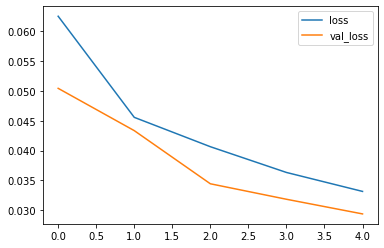

In [27]:
# Plot the performance
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [28]:
# Sample Prediction
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [29]:
res = model.predict(input_text)

In [30]:
(res > 0.5).astype(int)

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [31]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [32]:
(model.predict(batch_X) > 0.5).astype(int)

array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [1, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [35]:
# Lets Evaluate our model
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [36]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

In [37]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8961488008499146, Recall:0.7778571248054504, Accuracy:0.5020059943199158


In [38]:
# Run it on an interface

In [40]:
import gradio as gr

In [43]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text


In [44]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

/opt/conda/lib/python3.7/site-packages/gradio/inputs.py:28: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
/opt/conda/lib/python3.7/site-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/opt/conda/lib/python3.7/site-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)


In [45]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://12712d7b-f436-4e07.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
